In [1]:
# simmulate sounds in a grid of parameter values
# split the parameter space in n parallel processes
# then merge the files

from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
#from mpi4py import MPI
import h5py
import copy
import glob
import shutil

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
         '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
from swissknife.h5tools import h5tools
from swissknife.h5tools import tables
from swissknife.dynamo import finch as zf
from swissknife.dynamo import takens as tk
from swissknife.bci.core import expstruct as es
from swissknife.threadtools import threadedfunction as td

def splitlist(a, n):
    k, m = len(a) / n, len(a) % n
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def chunkify(lst,n):
    return [ lst[i::n] for i in range(n) ]

def sim_and_store(sim_pars, h5_file):
    sweep_group = h5_file.require_group(sim_pars['sweep_name'])
    h5tools.dict_2_group(sweep_group, sim_pars['vocal_pars'], 'vocal_pars')
    synth_group = sweep_group.require_group('synth')
    # create the group for the gamma
    gamma_group = synth_group.require_group('{0:5d}'.format(sim_pars['gamma']))
    sweep_table = tables.unlimited_rows_data(gamma_group, 'alpha_beta', 
                                             np.array([sim_pars['alpha'], 
                                                       sim_pars['beta']]).reshape([1,2]))
                                            
    
    alpha_values = sim_pars['alpha'] * np.ones(sim_pars['sim_samples'])
    beta_values = sim_pars['beta'] * np.ones(sim_pars['sim_samples'])
    env_values = np.ones(sim_pars['sim_samples'])
    par_stream = np.array([alpha_values, beta_values, env_values]).T
    for key in ['alpha', 'beta', 'gamma', 's_f', 'steps_per_sample']:
        vocal_pars['sys'][key] = sim_pars[key]
    song_synth = zf.finch(vocal_pars, par_stream, x_0=sim_pars['x_0'])
    pin_table = tables.unlimited_rows_data(gamma_group, 'pre_in', 
                                           song_synth[:,1].reshape([1,-1]))
    pout_table = tables.unlimited_rows_data(gamma_group, 'pre_out', 
                                            song_synth[:,0].reshape([1,-1]))

2017-10-08 11:10:17,960 root         INFO     Computer: txori


216


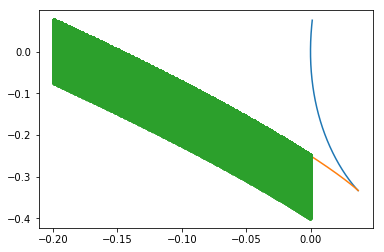

In [2]:
sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 24000.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6,
            'Rh': 6E5,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': 0.1,
            'noise_fraction_env': 0.1,
            's_f': 30000.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2,
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1,
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

#lines, ab_g= tk.cusp_grid()
lines, ab_g = tk.cusp_grid(b_max=0.075, b_min=-1 / 3, a_step=1.5E-3, b_steps=10000, b_log_step_exp=6, f_max=None)
plt.plot(lines[:,1], lines[:,0])
plt.plot(lines[:,2], lines[:,0])
plt.plot(ab_g[:,0], ab_g[:,1], '.')

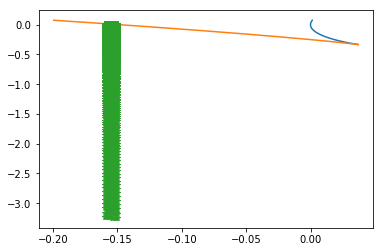

In [3]:
# upper line
plt.plot(lines[:,1], lines[:,0])
# lower line
plt.plot(lines[:,2], lines[:,0])
#get values that are a<0, b<lowerline

def cusp_grid(b_span, b_steps, a_max=-.15, a_min=-0.16, a_step=1e-3, b_log_step_exp=200):
    lines = tk.cusp_lines(step=a_step)
    b_sweep = np.logspace(0, b_log_step_exp, b_steps)*b_span  / (10 ** (b_log_step_exp))
    ab_grid = []
    for a in np.linspace(a_max, a_min, int(abs(a_max - a_min)/a_step)):
        b_m = lines[np.where(lines[:,2] < a)[0][0], 0]
        for b in b_sweep:
            ab_grid.append([a, b_m - b])
        
    return b_sweep, np.array(ab_grid)
        
l, abg = cusp_grid(3.25, 20000)
plt.plot(np.array(abg)[:,0], np.array(abg)[:,1], '*');

In [4]:
aba = np.array(abg)
aba.shape

(200000, 2)

In [5]:
es.file_names('')['locations']['experiment']

'/mnt/cube/earneodo/bci_zf'

In [6]:
sweep_id = '004'
sweep_name = 'sweep_'+sweep_id
file_name_base = 'finch_'+sweep_id 
sweep_folder = os.path.join(es.file_names('')['locations']['experiment'], 'syn_sweeps')
sweep_file_name = '{}.h5'.format(file_name_base)
sweep_file_path = os.path.join(sweep_folder, sweep_file_name)

sim_pars = {'sweep_name' : sweep_name,
            'folder': sweep_folder,
            'file_name': sweep_file_name,
            'file_path': sweep_file_path,
            
            'gamma': 24000,
            'alpha': 0.,
            'beta': 0.,
            'vocal_pars': vocal_pars,
            'sim_samples': 3000,
            's_f': 30000.,
            'steps_per_sample': 20,
            'x_0': np.array([5.E-12, 1.E-11, 1.E-12, 1.E-11, 1.E-12])
           }

#s.mkdir_p(os.path.split(h5_path)[0])


def merge_sweeps(source_file_path, dest_file_path, sim_pars):
    logger.info('Merging sweep in {} into {}'.format(source_file_path, dest_file_path))
    for table_name in ['alpha_beta', 'pre_in', 'pre_out']:
        table_path = '/{0}/synth/{1}/{2}'.format(sim_pars['sweep_name'], sim_pars['gamma'], table_name)
        tables.merge_tables(source_file_path, dest_file_path, table_path)
    logger.info('Table merged')

def merge_all_sweeps(pars, mode='x'):
    logger.info('Merging all sweeps for {}'.format(pars['sweep_name']))
    
    files_list=glob.glob(os.path.join(pars['folder'], pars['file_name'] + '.*'))
    files_list.sort()
    logger.info('Found {} sweep files'.format(len(files_list)))
    if mode=='x' or (not os.path.isfile(pars['file_path'])):
        logger.info('Copying first file to {}'.format(pars['file_path']))
        shutil.copy2(files_list.pop(0), pars['file_path'])
    else: 
        logger.info('Appending sweeps to existing file {}'.format(pars['file_path']))
    
    for source_file in files_list:
        merge_sweeps(source_file, pars['file_path'], pars)

@h5tools.h5_decorator(leave_open=False)
def sweep_to_file(h5_path, ab_list, sim_pars, mode='x'):
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2}'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path))
    try:
        total_sim = ab_list.shape[0]
        count = 0
        round_count = 0
        
        for sim_pars['alpha'], sim_pars['beta'] in np.nditer([ab_list[:,0], ab_list[:,1]]):
            if round_count==0:
                logger.info('Simulating {0}/{1} with {2}, {3}'.format(count,
                                                                  total_sim, 
                                                                  sim_pars['alpha'],
                                                                  sim_pars['beta']))
                round_count = 100
                count+= 100
            sim_and_store(sim_pars, h5_path)
            round_count-=1
        logger.info('Sweep done successfully')
    except UnboundLocalError as err:
        logger.error(err)


def parallel_sweep(h5_path, ab_list, sim_pars, mode='x', threads=1):
    es.mkdir_p(os.path.split(h5_path)[0])
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2} in {3} threads'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path, threads))
    try:
        sweep_threads = []
        f = h5py.File(h5_path, mode, driver='mpio', comm=MPI.COMM_WORLD)
        for chunk in chunkify(range(ab_list.shape[0]), threads):
            a_sweep = td.threadedFunction(args=(sweep_to_file,
                                                f,
                                                ab_list[chunk, :],
                                                sim_pars))
            a_sweep.start()
            sweep_threads.append(a_sweep)
        logger.info('Parallel sweep done successfully')
    except UnboundLocalError as err:
        f.close()
        logger.error(err)
        
def parallel_files_sweep(h5_path, ab_list, sim_pars, mode='x', threads=1):
    file_path = os.path.split(h5_path)[0]
    file_name = os.path.split(h5_path)[-1]
    
    es.mkdir_p(file_path)
    logger.info('Sweeping {0} values of alpha, beta with g={1} to file {2} in {3} threads'.format(
            ab_list.shape[0], sim_pars['gamma'], h5_path, threads))
    try:
        sweep_threads = []
        sim_pars_base = []
        f_chunk_paths = []
        for i_chunk, chunk in enumerate(chunkify(range(ab_list.shape[0]), threads)):
            f_chunk_path = os.path.join(file_path, file_name + '.{}'.format(i_chunk))
            f_chunk_paths.append(f_chunk_path)
            sim_pars_base.append(copy.deepcopy(sim_pars))
            a_sweep = td.threadedFunction(args=(sweep_to_file,
                                                f_chunk_path,
                                                ab_list[chunk, :],
                                                sim_pars_base[i_chunk]),
                                         kwargs = {'mode':mode})
            a_sweep.start()
            sweep_threads.append(a_sweep)
            
        logger.info('Will wait for {} sweeps to end before merging'.format(len(sweep_threads)))
        sweeps_merge = td.threadedFunction(name='merge_{}'.format(sim_pars['sweep_name']),
                                           args=(merge_all_sweeps,
                                                 sim_pars),
                                           kwargs={'mode':mode})
        for i_sweep, sweep_thread in enumerate(sweep_threads):
            sweep_thread.join()
            logger.info('Thread {} done'.format(sweep_thread.name))
        logger.info('Done with all sweeps')
        sweeps_merge.start()
        
    except UnboundLocalError as err:
        f.close()
        logger.error(err)
    
    return sweep_threads + [sweeps_merge], sim_pars_base
    

par_list = np.array([np.linspace(-.15, -.3, 2), np.linspace(0, -.5, 2)]).T
#sweep_to_file(sweep_file_path, ab_g, sim_pars, mode='a')
#parallel_sweep(sweep_file_path, ab_g, sim_pars, mode='a')
#merge_all_sweeps(sim_pars)

In [7]:
log_path = os.path.split(sweep_file_path)[0]
log_file = os.path.split(sweep_file_path)[1].split('.')[0] + '.log'
log_file_path = os.path.join(log_path, log_file)


#handler = logging.StreamHandler()
handler = logging.FileHandler(log_file_path)
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s (%(threadName)-10s) %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [8]:
par_process = td.threadedFunction(args=(parallel_files_sweep, 
                                        sweep_file_path, 
                                        abg[:,:], 
                                        sim_pars),
                                  kwargs={'mode':'a',
                                          'threads':6})
par_process.start()

2017-10-08 11:10:25,092 threadtools.threadedfunction INFO     Starting function  in thread threadedFunction-1
2017-10-08 11:10:25,096 root         INFO     Sweeping 200000 values of alpha, beta with g=24000 to file /mnt/cube/earneodo/bci_zf/syn_sweeps/finch_004.h5 in 6 threads
2017-10-08 11:10:25,111 threadtools.threadedfunction INFO     Starting function  in thread threadedFunction-1:1
2017-10-08 11:10:25,115 root         INFO     Sweeping 33334 values of alpha, beta with g=24000 to file <HDF5 file "finch_004.h5.0" (mode r+)>
2017-10-08 11:10:25,116 root         INFO     Simulating 0/33334 with -0.15, 0.0037037037037037646
2017-10-08 11:10:25,123 threadtools.threadedfunction INFO     Starting function  in thread threadedFunction-1:2
2017-10-08 11:10:25,127 root         INFO     Sweeping 33334 values of alpha, beta with g=24000 to file <HDF5 file "finch_004.h5.1" (mode r+)>
2017-10-08 11:10:25,128 root         INFO     Simulating 0/33334 with -0.15, 0.0037037037037037646
2017-10-08 11:

In [19]:
sim_pars

{'alpha': 0.0,
 'beta': 0.0,
 'file_name': 'finch_004.h5',
 'file_path': '/mnt/cube/earneodo/bci_zf/syn_sweeps/finch_004.h5',
 'folder': '/mnt/cube/earneodo/bci_zf/syn_sweeps',
 'gamma': 24000,
 's_f': 30000.0,
 'sim_samples': 3000,
 'steps_per_sample': 20,
 'sweep_name': 'sweep_004',
 'vocal_pars': {'A_1': 0.0,
  'A_2': None,
  'A_3': None,
  'S_1': 0.2,
  'S_2': 0.2,
  'S_3': 0.2,
  'l_1': 1.5,
  'l_2': 1.5,
  'l_3': 1.0,
  'max_tau': None,
  'r_12': None,
  'r_21': None,
  'r_23': None,
  'r_32': None,
  'r_out': 0.1,
  'sys': {'Ch_inv': 45000000000.0,
   'Lb_inv': 0.0001,
   'Lg_inv': 0.012195121951219513,
   'Rb': 5000000.0,
   'Rh': 600000.0,
   'V_ext': 0.0,
   'alpha_1': 0.15,
   'alpha_2': 0.15,
   'beta_1': 0.15,
   'beta_2': 0.15,
   'dV_ext': 0.0,
   'envelope': 0.0,
   'gamma': 24000.0,
   'noise': 0.0,
   'noise_fraction_beta_1': 0.1,
   'noise_fraction_env': 0.1,
   's_f': 30000.0,
   'steps_per_sample': 20},
  't_12': None,
  't_21': None,
  't_23': None,
  't_32': None

In [91]:
def merge_sweeps(source_file_path, dest_file_path, sim_pars):
    logger.info('Merging sweep in {} into {}'.format(source_file_path, dest_file_path))
    for table_name in ['alpha_beta', 'pre_in', 'pre_out']:
        table_path = '/{0}/synth/{1}/{2}'.format(sim_pars['sweep_name'], sim_pars['gamma'], table_name)
        tables.merge_tables(source_file_path, dest_file_path, table_path)
    logger.info('Table merged')

def merge_all_sweeps(pars):
    logger.info('Merging all sweeps for {}'.format(pars['sweep_name']))
    
    files_list=glob.glob(os.path.join(pars['folder'], pars['file_name'] + '.*'))
    files_list.sort()
    logger.info('Found {} sweep files'.format(len(files_list)))
    logger.info('Copying first file to {}'.format(pars['file_path']))
    shutil.copy2(files_list.pop(0), pars['file_path'])
    
    for source_file in files_list:
        merge_sweeps(source_file, pars['file_path'], pars)

#merge_sweeps(parallel_files_list[0], sweep_file_path, sim_pars)

merge_all_sweeps(sim_pars)

2016-10-26 16:51:32,158 root         INFO     Merging all sweeps for sweep_000
2016-10-26 16:51:32,160 root         INFO     Found 6 sweep files
2016-10-26 16:51:32,161 root         INFO     Copying first file to /usr/local/experiment/tmp_data/syn_sweeps/finch_000.h5
2016-10-26 16:51:38,112 root         INFO     Merging sweep in /usr/local/experiment/tmp_data/syn_sweeps/finch_000.h5.1 into /usr/local/experiment/tmp_data/syn_sweeps/finch_000.h5
2016-10-26 16:51:38,114 root         DEBUG    Appending table /sweep_000/synth/23500/alpha_beta from file /usr/local/experiment/tmp_data/syn_sweeps/finch_000.h5.1 into file /usr/local/experiment/tmp_data/syn_sweeps/finch_000.h5
2016-10-26 16:51:38,116 root         DEBUG    Appending /sweep_000/synth/23500/alpha_beta onto /sweep_000/synth/23500/alpha_beta
2016-10-26 16:51:38,117 root         DEBUG    Counting channels
2016-10-26 16:51:38,118 root         INFO     Channel count: 2
2016-10-26 16:51:38,119 root         DEBUG    About to append 0 enti